In [6]:
%matplotlib inline
import pandas as pd
import json
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
#import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

In [1]:
print("test")

test


In [8]:

boston_taz= gpd.read_file("boston_taz.json")

In [9]:
#https://catalog.data.gov/dataset/tiger-line-shapefile-2015-state-massachusetts-primary-and-secondary-roads-state-based-shapefile
roads = gpd.GeoDataFrame.from_file("tl_2015_25_prisecroads.shp")

In [10]:
boston_taz.head(5)

taz  town_id           town     shape_len    shape_area  \
0  2684      145       KINGSTON  21265.462815  1.721613e+07   
1  1977      116      GROVELAND  20208.802636  1.374014e+07   
2  2692       52         CARVER  18537.011185  1.619847e+07   
3  2634      182  MIDDLEBOROUGH  25202.872436  2.643507e+07   
4  1080      189         MILTON   8351.001509  1.549062e+06   

               DISPLAY_NAME MOVEMENT_ID  \
0       KINGSTON, 2684 (35)          35   
1      GROVELAND, 1977 (42)          42   
2         CARVER, 2692 (45)          45   
3  MIDDLEBOROUGH, 2634 (58)          58   
4         MILTON, 1080 (63)          63   

                                            geometry  
0  (POLYGON ((-70.74139 41.99228, -70.74128 41.99...  
1  (POLYGON ((-70.96719 42.75828, -70.95968999999...  
2  (POLYGON ((-70.68978 41.83894, -70.68980000000...  
3  (POLYGON ((-70.87072999999999 41.94901, -70.87...  
4  (POLYGON ((-71.04276 42.27673, -71.04258 42.27...

In [11]:
all_data= pd.read_csv("boston-taz-2017-3-All-HourlyAggregate.csv")
taz_ = json.loads(open('boston_taz.json').read())

In [14]:
lengths = []
for hour in range(24):
    lengths.append(len(all_data[all_data['hod']==hour]))

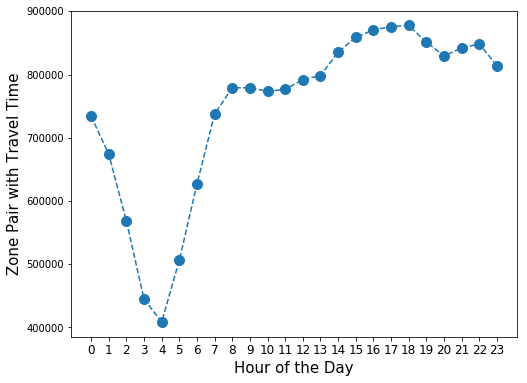

In [68]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(24),lengths,'o--',markersize=10)
plt.xticks(np.arange(0,24,1), fontsize=12)
plt.xlabel("Hour of the Day", fontsize=15)
plt.ylabel("Zone Pair with Travel Time", fontsize=15)
#plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.savefig('LENGTH_BOSTON.pdf',bbox_inches='tight',dpi=1000)

In [16]:
x = np.arange(24)

print(x[lengths.index(max(lengths))])
print(x[lengths.index(min(lengths))])

18
4


([], <a list of 0 Text yticklabel objects>)

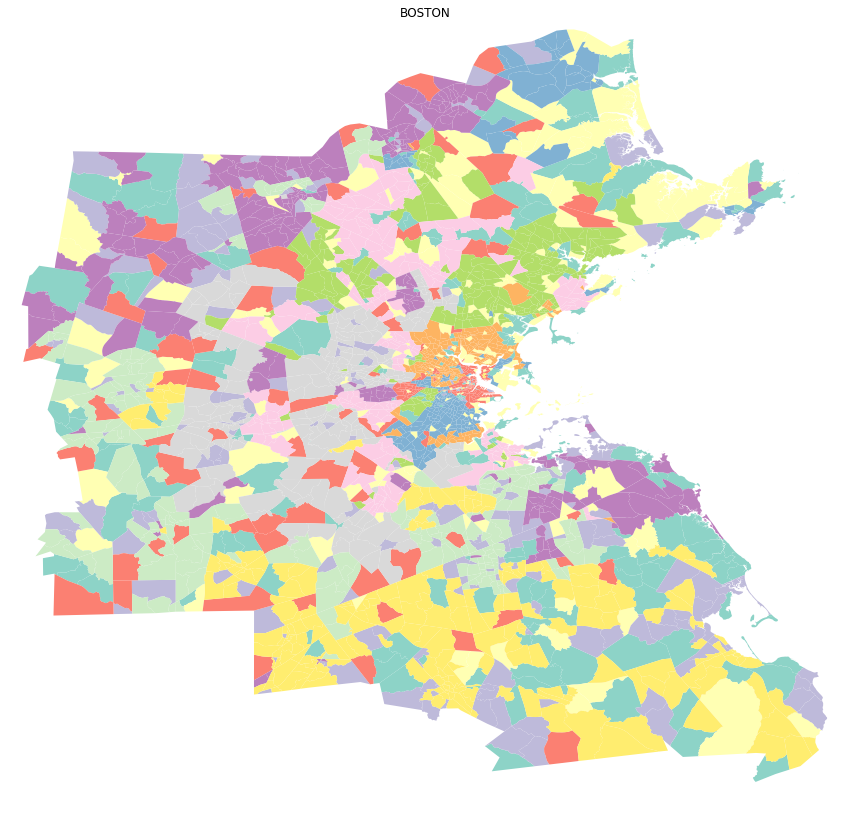

In [17]:
west=-71.75
south=41.699
east=-70.5
north=42.8973

ax = boston_taz.plot(figsize=(15,20),zorder=1,cmap='Set3')

#ADD CENTROIDS
centroids = boston_taz.centroid
boston_taz['centroid'] = centroids
centroids.head()
#centroids.plot(c='black',ax=ax, zorder=1,markersize=2)


#edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="white")
plt.title("BOSTON") #date
plt.xlim(west,east)
plt.ylim(south,north)
plt.axis('off')
plt.xticks([])
plt.yticks([])

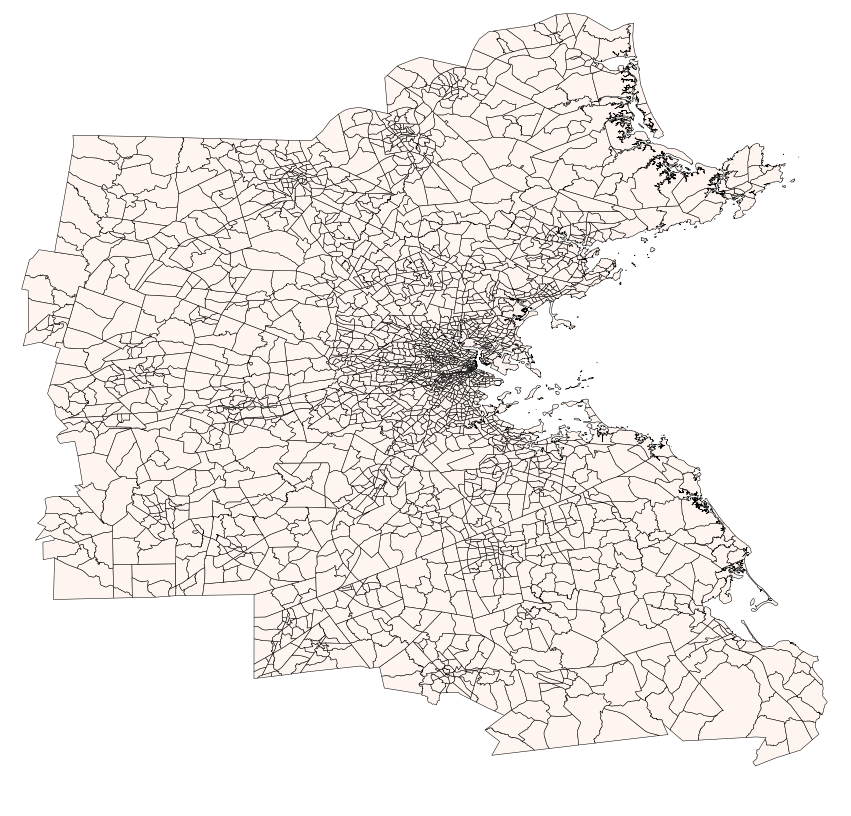

In [19]:
west=-71.75
south=41.699
east=-70.5
north=42.8973
boston_taz['centroid'] = 0
ax = boston_taz.plot(figsize=(15,20),column='centroid',zorder=1,cmap='Reds',edgecolor='black',linewidth=0.5)

#ADD CENTROIDS
#centroids = boston_taz.centroid

centroids.head()
#centroids.plot(c='black',ax=ax, zorder=1,markersize=2)


#edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="white")
#plt.title("BOSTON") #date
plt.xlim(west,east)
plt.ylim(south,north)
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.savefig("boston_preprocess.pdf",bbox_inches='tight',dpi=1000)

### PREPROCESSING

In [15]:
features_taz = taz_['features']
print(len(features_taz))
places_taz=[x['properties']['DISPLAY_NAME'] for x in features_taz]
id_numbers_taz=[int(x['properties']['MOVEMENT_ID']) for x in features_taz]
citiesfreq = {}
cities=[]
#Obtain frequency of cities/municipalities
for place in places_taz:
    place=[x.strip() for x in place.split(',')] #Take place string and split by comma
    cities.append(place[0])
    if place[0] in citiesfreq.keys():
        citiesfreq[place[0]]+=1
        #print(split_display[-1])
    else:
        citiesfreq[place[0]]=1
import operator
citiesfreq = sorted(citiesfreq.items(), key=operator.itemgetter(1), reverse=True)
places = [x for x,y in citiesfreq]
top10places = places[:10]

idANDcity = [(x,y) for x,y in zip(id_numbers_taz,cities)]
idANDcity = sorted(idANDcity, key=operator.itemgetter(0))

2728


In [9]:
def getCentrality(hour,kind):
    data= all_data[all_data['hod']==hour]
    Score = []
    
    #for i in range(1,len(features_taz)+1):
    for i in id_numbers_taz:
        if kind.lower() == 'in':
            destinations = data[(data['dstid']==(i))] #IN DEGREE
        elif kind.lower() =='out':
            destinations = data[(data['sourceid']==(i))] # OUT DEGREE
        Score.append(len(destinations))
    Score = np.array(Score)/(len(features_taz)-1) #NORMALIZE BY NUMBER OF ZONES AND ADD CENTRALITY VALUES AS COLUMN TO GEOJSON DATAFRAME
    #Score = np.array(Score)/np.sum(Score) #NORMALIZE BY SUM AND ADD CENTRALITY VALUES AS COLUMN TO GEOJSON DATAFRAME
    Score = np.array(Score) #
    
    
    
    boston_taz['{}_Centrality'.format(kind)] = 0 
    #for index,value in enumerate(Score):
    for index, i in enumerate(id_numbers_taz):
           boston_taz.loc[boston_taz.MOVEMENT_ID == str(i),['{}_Centrality'.format(kind)]] = Score[index]
    #add score to idANDcity array 
    idcityANDscore = [(x[0],x[1],y) for x,y in zip(idANDcity,Score)]
    return idcityANDscore   


In [64]:
def ccdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n= len(data)

    # x-data for the CCDF: x
    x = np.sort(data)

    # y-data for the CCDF: y
    y = (1- (np.linspace(0, n, n) / n))*100 #multiply 100 to obtain percentage
    
    # y-data for ECDF: y
    #y = (np.arange(1, n+1) / n)
    return x, y

In [26]:
def get_CCDF(kind):
    def CentralityProfile_2(results,city):
        zonesinCity = []
    
        for i in results:
            if i[1] == city:
                zonesinCity.append(i)
        zonesinCity = sorted(zonesinCity,key=operator.itemgetter(2),reverse=True)
        return zonesinCity
    citycentralities2 = []
    for i in places:
        if kind =='out':
            citycentralities2.append(CentralityProfile_2(out_results,i))
        elif kind=='in':
            citycentralities2.append(CentralityProfile_2(in_results,i))
            
    def CentralityProfile_BETTER(citycentralities):
        #Get maximum centrality per city
        maxes= []
        for i in citycentralities:
            maxes.append(max(i,key=operator.itemgetter(2))[2])

        #Make array containing id , city/town , centrality, and maximum centrality
        citycentralities = [(x,y) for x,y in zip(citycentralities,maxes)]

        #Sort based on decreasing maximum centrality
        citycentralities = sorted(citycentralities, key=operator.itemgetter(1),reverse=True)

        #Get original array of tuples without maxes
        citycentralities = [x for x,y in citycentralities]

        top10basedcentrality = [] # Top 10 based on centrality
        for i in citycentralities:
            top10basedcentrality.append(i[0][1]) #Get the city by getting the 2nd element (index 1) of the first element of each sub array.        
        #print(top10basedcentrality)
        #Make array containing centralities only
        centralityvalues = []
        for i in citycentralities:
            centralityvalues.append([z for x,y,z in i])

        #Make array of 0 to 1 values for every set of centrality values for each city so that we can plot all of them together
        x = []
        for i in centralityvalues:
            zerotoone = [ t/(len(i)-1) for t in range(len(i))]
            x.append(zerotoone)

        xANDcentralities = []
        for i in range(len(centralityvalues)):
            xANDcentralities.append([(x,y) for x,y in zip(x[i],centralityvalues[i])])
        return xANDcentralities,top10basedcentrality
    
    #citycentralities2[25]
    #Get how many zones in each Origin have data:
    zeroes = [0 for x in range(len(places))]
    counts = {key:value for key,value in zip(places,zeroes)}
    for city in citycentralities2:
        for x,y,z in city:
            if z!=0:
                counts[y]+=1
    counts = sorted(counts.items(),key=operator.itemgetter(1),reverse=True)
    
    #top10places2 =  [x for x,y in counts[:10]]
    top10places2 =  ['LYNN', 'CAMBRIDGE', 'SOMERVILLE', 'QUINCY', 'WALTHAM', 'NEWTON', 'LOWELL', 'FRAMINGHAM', 'BOSTON', 'BROCKTON']
    citycentralities2_new = []
    for i in citycentralities2:
        if i[0][1] in top10places2:
            citycentralities2_new.append(i)
    
    xANDcentralities2 = CentralityProfile_BETTER(citycentralities2_new)[0]
    top10basedcentrality2 = CentralityProfile_BETTER(citycentralities2_new)[1]
    
    xANDcentralities_median = []
    for i in range(len(xANDcentralities2)):
        y = [y for x,y in xANDcentralities2[i]]
        median = np.median(y)
        new_array = [xANDcentralities2[i],median,top10basedcentrality2[i]]
        xANDcentralities_median.append(new_array)
    xANDcentralities_median = sorted(xANDcentralities_median, key=lambda x: x[1], reverse=True)
    orig_order = [z for x,y,z in xANDcentralities_median]

    order = ['LYNN', 'CAMBRIDGE', 'SOMERVILLE', 'QUINCY', 'WALTHAM', 'NEWTON', 'LOWELL', 'FRAMINGHAM', 'BOSTON', 'BROCKTON']

    #if kind=='in':
        #order = ['SOMERVILLE','LYNN','CAMBRIDGE','QUINCY','NEWTON','WALTHAM','FRAMINGHAM','LOWELL','BROCKTON','BOSTON']
    #elif kind=='out':
        #order = ['CAMBRIDGE','LYNN','SOMERVILLE','QUINCY','NEWTON','WALTHAM','LOWELL','FRAMINGHAM','BOSTON','BROCKTON']
    new=[]
    for num in order:
        for index,value in enumerate(xANDcentralities_median):
            #print(value[2])
            if value[2] == num:
                new.append(value)
    ccdf_data = new
    return ccdf_data

In [27]:

def plot_CCDF(kind):
    xANDcentralities_median = get_CCDF(kind)
    
    plt.figure(figsize=(8,6))

    plt.plot(np.linspace(0,1,100),[50 for i in range(100)],linestyle='--',color='black')
    if hour ==4:
        plt.plot([0.134 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
    elif hour == 18:
        plt.plot([0.265 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
    for i in range(len(xANDcentralities_median)):
        # Compute ECDF for versicolor data: x_vers, y_vers
        x_vers, y_vers = ccdf([y for x,y in xANDcentralities_median[i][0]])

        # Generate plot
        plt.plot(x_vers,y_vers,marker='o',linestyle='-',markersize=2,alpha=0.75,label=xANDcentralities_median[i][2])

    #plt.plot(np.linspace(0,0.25,100),[14 for i in range(100)],linestyle='--',color='black')
    #plt.plot([0.1 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')

    # Make the margins nice
    plt.margins(0.01)

    # Label the axes
    plt.ylabel('CCDF (%)',fontsize=15)
    plt.xlabel("Centrality ($d_{i}$)",fontsize=14)
    plt.legend(fontsize=15)
    #set xtick and y tick fontsize
    plt.yticks(np.arange(0,101,5),fontsize=14)
    plt.xticks(np.linspace(0,0.80,5),fontsize=14)
    plt.ylim(-1,101)
    plt.xlim(-0.001,0.80)
    #plt.xlim(-0.001,max(out_centralities)+0.05)
    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.tight_layout()
    plt.savefig('{}_DEGREE_BOSTON_CCDF_hour_{}.pdf'.format(kind,hour),dpi=1000)

In [28]:
def percent_CCDF(kind,percent):   
    xANDcentralities_median = get_CCDF(kind)
    for i in range(len(xANDcentralities_median)):
        # Compute ECDF for versicolor data: x_vers, y_vers
        x_vers, y_vers = ccdf([y for x,y in xANDcentralities_median[i][0]])
        differences = []
        for index,value in enumerate(y_vers):
            differences.append(abs(percent-value))
        print("{}% of".format(percent), xANDcentralities_median[i][2],"has at least a centrality value of :",round(x_vers[differences.index(min(differences))],3))

In [29]:
def cent_CCDF(kind,cent):
    xANDcentralities_median = get_CCDF(kind)
    target = cent
    for i in range(len(xANDcentralities_median)):
        x_vers, y_vers = ccdf([y for x,y in xANDcentralities_median[i][0]])
        differences = []
        for index,value in enumerate(x_vers):
            differences.append(abs(target-value))
        if max(x_vers)>=target:
            print(round(y_vers[differences.index(min(differences))],3),"% of", xANDcentralities_median[i][2],"has at least a centrality value of",target)
        else:
            print(str(0),"% of", xANDcentralities_median[i][2],"has at least a centrality value of",target)
        #print("Maximum centrality of city:",max(x_vers))

### GET CENTRALITY VALUES FOR ALL HOURS

In [ ]:
#for hour in [4,18]:
for hour in np.arange(1,24):
    in_results= getCentrality(hour,'in')
    out_results = getCentrality(hour,'out')

    centrality_geojson= boston_taz #.drop('centroid', axis=1)
    centrality_geojson.to_file("centrality_BOSTON_hour_{}.json".format(hour), driver="GeoJSON")

### CENTRALITY MAPS

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_map(boston_taz,kind,zoom=False,linewidth=0.0,set_bar=True,hour=3):
    if zoom==False:
        westlimit=-71.75
        southlimit=41.699
        eastlimit=-70.5
        northlimit=42.8973
        
        #westlimit=-71.400127; southlimit=42.199194; eastlimit=-70.900868; northlimit=42.597967
    else:
        #westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.985042; northlimit=42.45717
        westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.950; northlimit=42.45717
    #westlimit=-71.218845; southlimit=42.258002; eastlimit=-70.963413; northlimit=42.414095
    #vmin, vmax = 0, 0.80
    vmin = 0
    if kind =='in':
        vmaxx = 0.75
        print(max(boston_taz.in_Centrality.values))
    else:
        vmaxx = 0.75
        print(max(boston_taz.out_Centrality.values))
    #print(vmaxx)
    
    if set_bar==True:
        vmax = 1
    elif set_bar == False:
        vmax = round(vmaxx,2)
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)

    ax = boston_taz.plot(figsize=(10,10),column='{}_Centrality'.format(kind),cmap='gist_heat_r',vmin=vmin, vmax=vmax,zorder=1,linewidth=linewidth,edgecolor='black')
    #plt.title(date) #date
    ax.axis('off')
    
    plt.xlim(westlimit,eastlimit)
    plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    #ADD ROADS LAYER
    #edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="blue")
    roads.plot(ax=ax,color='cyan',alpha=0.35,edgecolor='black', linewidth=0.35,zorder=2)
    #PLACE COLORBAR
    fig = ax.get_figure()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.025)
    sm = plt.cm.ScalarMappable(cmap='gist_heat_r', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []

    cbar = fig.colorbar(sm, cax=cax)
    if zoom==False:
        plt.savefig("{}_centrality_map_BOSTON_hour_{}.pdf".format(kind,hour) ,bbox_inches='tight', dpi=1000)
    else:
        plt.savefig("{}_centrality_map_BOSTON_zoom_hour_{}.pdf".format(kind,hour), bbox_inches='tight', dpi=1000)
    plt.show()
    #plt.savefig("{}_centrality_map_SFO.pdf".format(kind), dpi=1000)

In [21]:
hour4 = gpd.read_file("centrality_BOSTON_hour_4.json")
hour18 = gpd.read_file("centrality_BOSTON_hour_18.json")

In [22]:
print(hour4.in_Centrality.values.max())
print(hour4.out_Centrality.values.max())
print(hour18.in_Centrality.values.max())
print(hour18.out_Centrality.values.max())

0.7403740374037404
0.4121745507884122
0.656032269893656
0.6941694169416942


0.656032269893656


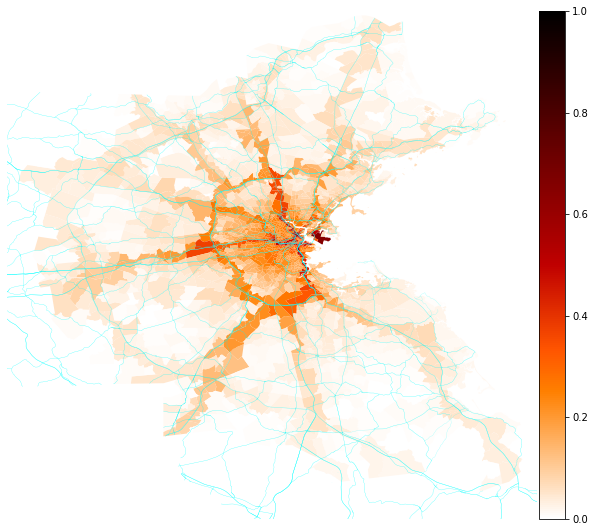

In [95]:
plot_map(hour18,'in',False)

0.7403740374037404


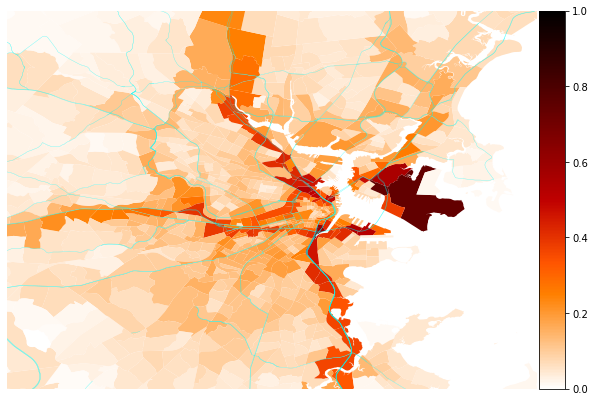

In [119]:
plot_map(hour4,'in',True)

0.4121745507884122


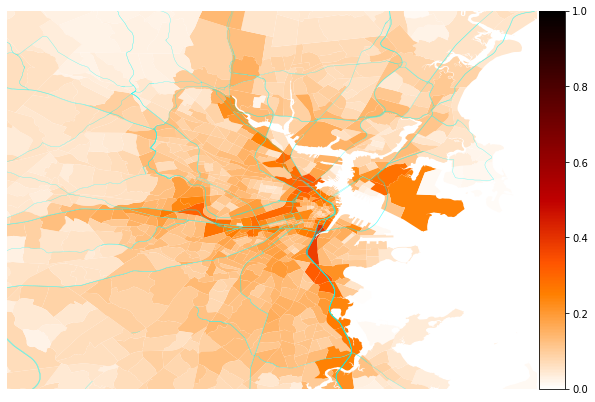

In [36]:
plot_map(hour4,'out',True,0.0,True,4)

0.7403740374037404


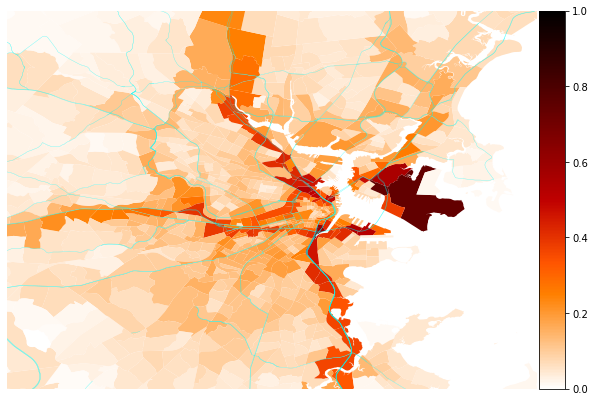

In [37]:
plot_map(hour4,'in',True,0.0,True,4)

0.6941694169416942


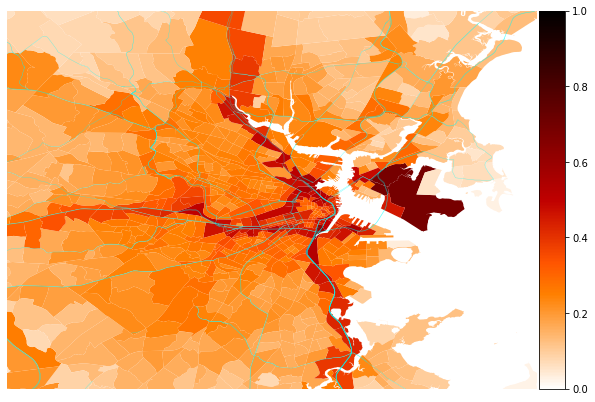

In [38]:
plot_map(hour18,'out',True,0.0,True,18)

0.656032269893656


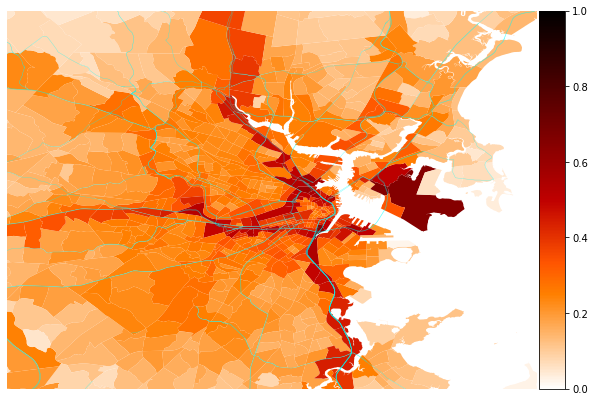

In [39]:
plot_map(hour18,'in',True,0.0,True,18)

In [93]:
plot_map(hour8,'in',True,0.0,False)

0.6982031536486982


In [77]:
np.arange(1,24)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])

In [72]:
hour8 = gpd.read_file('centrality_BOSTON_hour_8.json')
hour16 = gpd.read_file('centrality_BOSTON_hour_16.json')
hour17 = gpd.read_file('centrality_BOSTON_hour_17.json')

In [97]:
hour7 = gpd.read_file('centrality_BOSTON_hour_7.json')

In [100]:
hour22 = gpd.read_file('centrality_BOSTON_hour_22.json')

In [120]:
hour4 = gpd.read_file('centrality_BOSTON_hour_4.json')

In [132]:
hour18 = gpd.read_file('centrality_BOSTON_hour_18.json')

In [60]:
peak = hour18
off_peak = hour4

In [61]:
def get_order():
    for peak_ in [False,True]:
        for kind in ['in','out']:
            #print(kind , peak_)
            plt.figure(figsize=(8,6))
            towns = ['LYNN', 'CAMBRIDGE', 'SOMERVILLE', 'QUINCY', 'WALTHAM', 'NEWTON', 'LOWELL', 'FRAMINGHAM', 'BOSTON', 'BROCKTON']
            medians = []
            for town in towns:
                if peak_==True:
                    #peak = hour18
                    town_data = peak[peak.town == town]
                else:
                    #off_peak = hour4
                    town_data = off_peak[off_peak.town == town]
                max_ = max(town_data['{}_Centrality'.format(kind)].values)
                median_= np.median(town_data['{}_Centrality'.format(kind)].values)
                #print(town+"   max: " + str(max_) + "  median: " +  str(median_))

                medians.append(median_)
            town_med = zip(towns,medians)
            town_med = sorted(town_med, key=lambda x: x[1], reverse=True)
            if peak_ == False:
                if kind =='in':
                    in_towns = [x for x,y in town_med]
                elif kind=='out':
                    out_towns = [x for x,y in town_med]
    return in_towns,out_towns

### CENTRALITY PROFILES (CCDF)

In [66]:
def plot_ccdf():
    for peak_ in [False,True]:
        for kind in ['in','out']:
            print(kind , peak_)
            plt.figure(figsize=(8,6))
            if peak_ == False:
                if kind=='in':
                    towns = get_order()[0]
                    #plt.plot([0.134 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
        
                elif kind=='out':
                    towns = get_order()[1]
                    
            for index,town in enumerate(towns):
                if peak_==True:
                    town_data = peak[peak.town == town]
                else:
                    town_data = off_peak[off_peak.town == town]
                min_ = min(town_data['{}_Centrality'.format(kind)].values)
                max_ = max(town_data['{}_Centrality'.format(kind)].values)
                median_ = np.median(town_data['{}_Centrality'.format(kind)].values)
                print(town+"\t min:"+str(min_)+"\t max: " + str(max_) + "\t median: " +  str(median_))

                x,y = ccdf(town_data['{}_Centrality'.format(kind)].values)
                test_y = list(y)
                test_x = list(x)

                #test_y.append(0)
                #test_x.append(1)

                plt.plot(test_x,test_y,marker='o',linestyle='-',markersize=2,alpha=0.75,label=town)

                if index == 0:
                    if kind=='in':
                        top_in = median_
                    elif kind=='out':
                        top_out = median_

            #plt.plot(np.linspace(0,0.25,100),[14 for i in range(100)],linestyle='--',color='black')
            #plt.plot([0.1 for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
            plt.plot(np.linspace(0,1,100),[50 for i in range(100)],linestyle='--',color='black')
            if kind=='in':
                plt.plot([top_in for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
            else:
                plt.plot([top_out for i in range(100)],np.linspace(-5,100,100),linestyle='--',color='black')
            # Make the margins nice
            plt.margins(0.01)

            # Label the axes
            
            if kind == 'in':
                plt.ylabel('CCDF($d^{in}$)',fontsize=15)
                plt.xlabel("Centrality ($d^{in}$)",fontsize=15)
            else:
                plt.ylabel('CCDF($d^{out}$)',fontsize=15)
                plt.xlabel("Centrality ($d^{out}$)",fontsize=15)
            plt.legend(fontsize=15)
            #set xtick and y tick fontsize
            plt.yticks(np.arange(0,101,5),fontsize=14)
            plt.xticks(np.linspace(0,0.80,5),fontsize=14)
            plt.ylim(-1,101)
            plt.xlim(-0.001,0.80)
            #plt.xlim(-0.001,max(out_centralities)+0.05)
            plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
            if peak_ == False:
                hour = 4
            else:
                hour = 18
            plt.savefig('{}_DEGREE_BOSTON_CCDF_hour_{}.pdf'.format(kind,hour),bbox_inches='tight',dpi=1000)

In [ ]:
plot_ccdf()

### NET USAGE PATTERN MAPS

In [51]:
def get_diff(hour,zoom=True):
    vmin=-1
    vmax=1
    if hour == 8:
        hour_data = hour8
        
    elif hour == 16:
        hour_data = hour16
    elif hour == 17:
        hour_data = hour17
    elif hour == 7:
        hour_data = hour7 
    elif hour == 22:
        hour_data = hour22
    elif hour == 4:
        hour_data= hour4
    elif hour == 18:
        hour_data = hour18
    hour_data['diff'] = hour_data.apply(lambda row: row.in_Centrality - row.out_Centrality, axis=1)
    print(max(hour_data['diff'].values),min(hour_data['diff'].values))
    vmin= -max([abs(max(hour_data['diff'].values)),abs(min(hour_data['diff'].values))])
    vmax= max([abs(max(hour_data['diff'].values)),abs(min(hour_data['diff'].values))]) 
    
    if hour == 4:
        vmin = -0.5
        vmax= 0.5
    elif hour == 18:
        vmin = -0.5
        vmax = 0.5
    elif hour == 7:
        vmin = -0.23
        vmax = 0.23
    elif hour == 17:
        vmin = -0.23
        vmax = 0.23
    
    ax = hour_data.plot(figsize=(10,10),column='diff',cmap='seismic',vmin=vmin,vmax=vmax)
    

    if zoom==False:
        westlimit=-71.75
        southlimit=41.699
        eastlimit=-70.5
        northlimit=42.8973
        
        #westlimit=-71.400127; southlimit=42.199194; eastlimit=-70.900868; northlimit=42.597967
    else:
        #westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.985042; northlimit=42.45717
        westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.950; northlimit=42.45717
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.xlim(westlimit,eastlimit)
    plt.ylim(southlimit,northlimit)
    #PLACE COLORBAR
    fig = ax.get_figure()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap='seismic', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    plt.savefig("net_usage_boston_{}.pdf".format(hour) ,bbox_inches='tight', dpi=1000)

0.4961496149614962 -0.07664099743307665


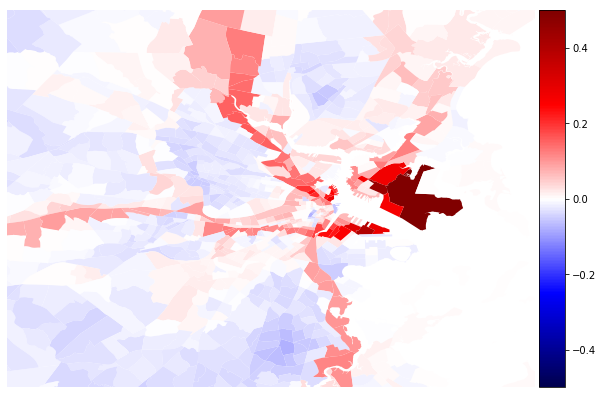

In [52]:
get_diff(4)

0.1323799046571324 -0.17895122845617895


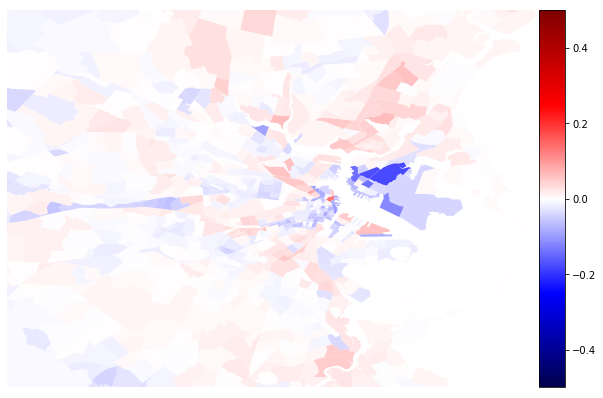

In [53]:
get_diff(18)

In [104]:
get_diff(8)

0.18995232856619 -0.12101210121012101


0.2291895856252292 -0.10377704437110379


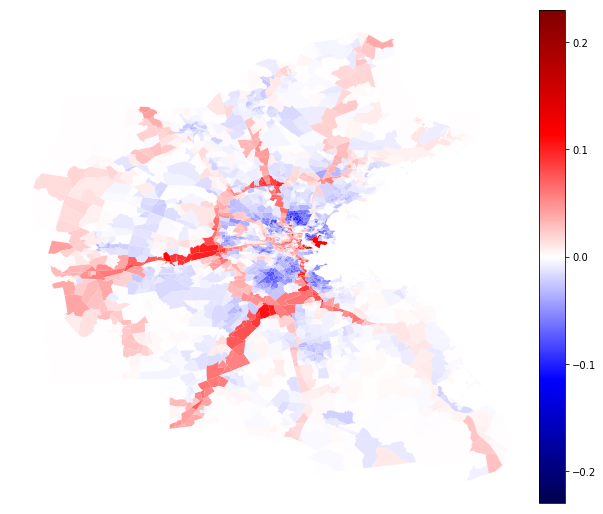

In [130]:
get_diff(7)

0.178951228456179 -0.15584891822515584


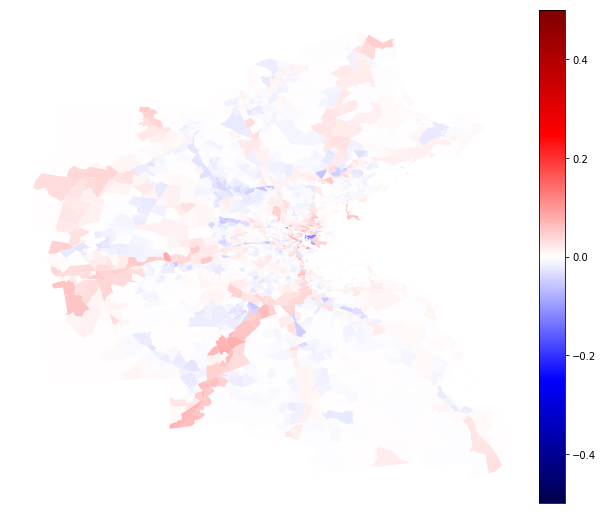

In [128]:
get_diff(16)

0.16648331499816643 -0.17271727172717272


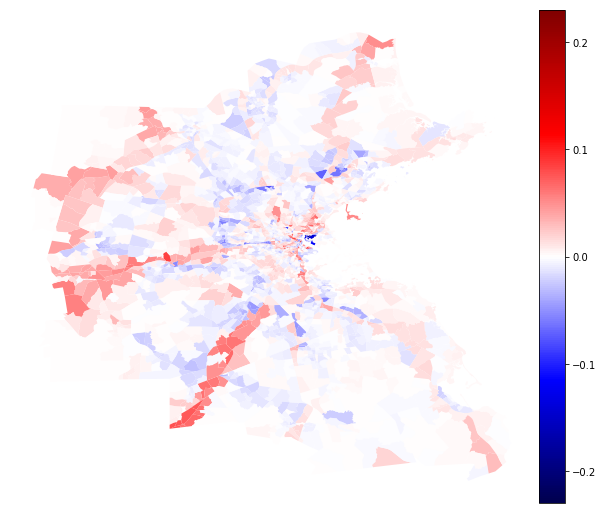

In [131]:
get_diff(17)

0.08324165749908324 -0.34250091675834254


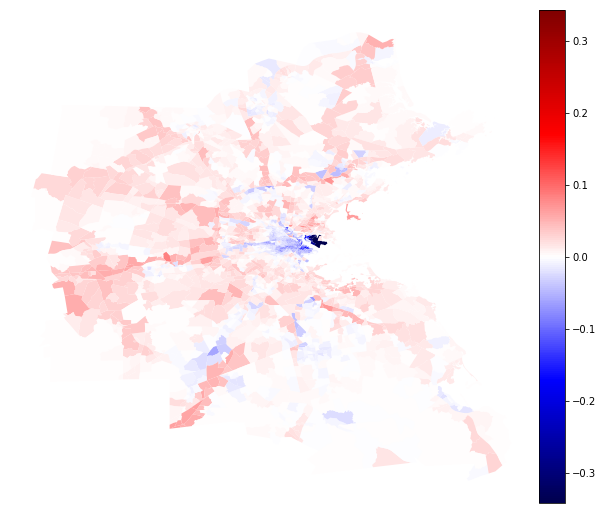

In [108]:
get_diff(22)

In [135]:
def city_ccdf(hour,kind):
    if hour == 8:
        hour_data = hour8
    elif hour == 7:
        hour_data = hour7
    elif hour == 17:
        hour_data = hour17
    elif hour == 16:
        hour_data = hour16
    elif hour == 3:
        hour_data = hour3
    elif hour == 4:
        hour_data = hour4
    elif hour ==18:
        hour_data = hour18
    if kind =='in':
        x,y = ccdf(hour_data.in_Centrality.values)
    else:
        x,y = ccdf(hour_data.out_Centrality.values)
        
    plt.figure(figsize=(8,6))

    plt.plot(x,y,marker='o',linestyle='-',markersize=2,alpha=0.75)
    plt.ylabel('CCDF ($d^{in}$)',fontsize=15)
    if kind == 'in':
        plt.xlabel("Centrality ($d^{in}$)",fontsize=15)
    else:
        plt.xlabel("Centrality ($d^{out}$)",fontsize=15)
    #plt.legend(fontsize=15)
    #set xtick and y tick fontsize
    plt.yticks(np.arange(0,101,5),fontsize=14)
    plt.xticks(np.linspace(0,1,5),fontsize=14)
    #plt.xticks(np.linspace(0,round(max(max(in_centralities),max(out_centralities)),2),5),fontsize=14)
    plt.ylim(-1,101)
    #plt.xlim(-0.001,max(max(in_centralities),max(out_centralities))+0.005)
    plt.xlim(-0.001,1)

    plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 

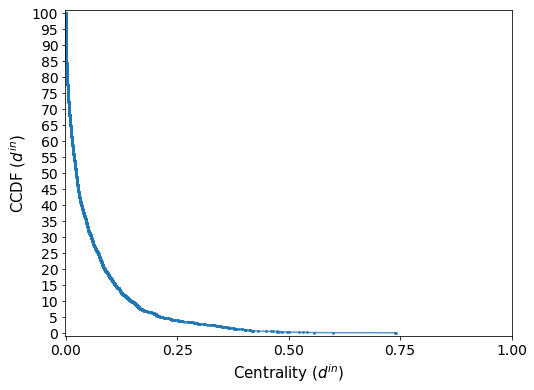

In [136]:
city_ccdf(4,'in')

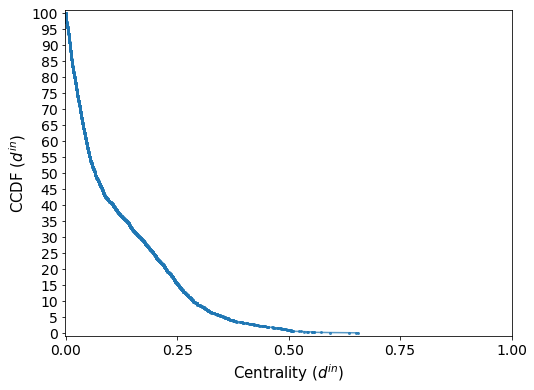

In [137]:
city_ccdf(18,'in')

## Zone finder

In [32]:
off_peak = gpd.read_file("centrality_BOSTON_hour_4.json")
peak = gpd.read_file("centrality_BOSTON_hour_18.json")

In [120]:
off_peak[off_peak['in_Centrality'] == off_peak['in_Centrality'].max()]

taz  town_id    town     shape_len    shape_area       DISPLAY_NAME  \
305  185       35  BOSTON  17349.936902  4.870562e+06  BOSTON, 185 (361)   

    MOVEMENT_ID  in_Centrality  out_Centrality  \
305         361       0.740374        0.244224   

                                              geometry  
305  (POLYGON ((-71.00615000000001 42.37908, -71.00...

In [121]:
peak[peak['in_Centrality'] == peak['in_Centrality'].max()]

taz  town_id    town    shape_len     shape_area       DISPLAY_NAME  \
909  183       35  BOSTON  2897.384159  337466.539931  BOSTON, 183 (351)   

    MOVEMENT_ID  in_Centrality  out_Centrality  \
909         351       0.656032        0.694169   

                                              geometry  
909  (POLYGON ((-71.02478000000001 42.36894, -71.02...

In [122]:
off_peak[off_peak['out_Centrality'] == off_peak['out_Centrality'].max()]

taz  town_id    town    shape_len     shape_area      DISPLAY_NAME  \
739   20       35  BOSTON  2377.472509  179016.624167  BOSTON, 20 (131)   

    MOVEMENT_ID  in_Centrality  out_Centrality  \
739         131        0.59956        0.412175   

                                              geometry  
739  (POLYGON ((-71.05703 42.34951, -71.05714999999...

In [123]:
peak[peak['out_Centrality'] == peak['out_Centrality'].max()]

taz  town_id    town    shape_len     shape_area       DISPLAY_NAME  \
909  183       35  BOSTON  2897.384159  337466.539931  BOSTON, 183 (351)   

    MOVEMENT_ID  in_Centrality  out_Centrality  \
909         351       0.656032        0.694169   

                                              geometry  
909  (POLYGON ((-71.02478000000001 42.36894, -71.02...

In [ ]:
peak[peak['TZ06_D00_'] == 6113]

In [42]:
def highlight(mov_id,zoom=False):
    boston_taz['highlight'] = 0
    
    boston_taz.loc[boston_taz.MOVEMENT_ID == str(mov_id),['highlight']] = 1
    
    if zoom==False:
        westlimit=-71.400127; southlimit=42.199194; eastlimit=-70.900868; northlimit=42.597967
    else:
        westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.985042; northlimit=42.45717
    vmin, vmax = 0, max(out_centralities)+0.05
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)

    ax = boston_taz.plot(figsize=(10,10),column='highlight',cmap='Reds',zorder=1,edgecolor='black',linewidth=0.1,categorical=True)
    #plt.title(date) #date
    ax.axis('off')
    plt.xlim(westlimit,eastlimit)
    plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    
    #roads.plot(ax=ax,color='yellow',alpha=0.2,edgecolor='blue', linewidth=2,zorder=2)
    #ADD ROADS LAYER
    #edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="blue")

    #PLACE COLORBAR
    fig = ax.get_figure()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.025)
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # fake up the array of the scalar mappable.
    sm._A = []

    cbar = fig.colorbar(sm, cax=cax)
    
    #plt.savefig("{}_centrality_map_SFO.pdf".format(kind), dpi=1000)
    

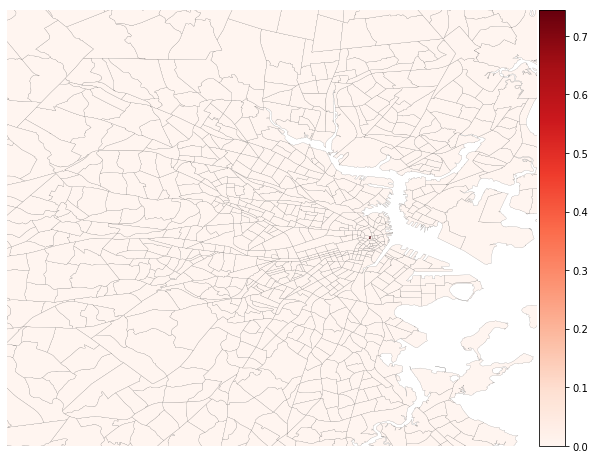

In [43]:
highlight(175,True)

In [135]:
highlight(351,True)

In [ ]:
highlight(351,False)

In [157]:
unique = np.unique(boston_taz.town.values)

In [158]:
unique

array(['ABINGTON', 'ACTON', 'AMESBURY', 'ANDOVER', 'ARLINGTON', 'ASHLAND',
       'ATTLEBORO', 'AVON', 'AYER', 'BEDFORD', 'BELLINGHAM', 'BELMONT',
       'BERLIN', 'BEVERLY', 'BILLERICA', 'BLACKSTONE', 'BOLTON', 'BOSTON',
       'BOXBOROUGH', 'BOXFORD', 'BRAINTREE', 'BRIDGEWATER', 'BROCKTON',
       'BROOKLINE', 'BURLINGTON', 'CAMBRIDGE', 'CANTON', 'CARLISLE',
       'CARVER', 'CHELMSFORD', 'CHELSEA', 'CLINTON', 'COHASSET',
       'CONCORD', 'DANVERS', 'DEDHAM', 'DOVER', 'DRACUT', 'DUNSTABLE',
       'DUXBURY', 'EAST BRIDGEWATER', 'EASTON', 'ESSEX', 'EVERETT',
       'FOXBOROUGH', 'FRAMINGHAM', 'FRANKLIN', 'GEORGETOWN', 'GLOUCESTER',
       'GROTON', 'GROVELAND', 'HALIFAX', 'HAMILTON', 'HANOVER', 'HANSON',
       'HARVARD', 'HAVERHILL', 'HINGHAM', 'HOLBROOK', 'HOLLISTON',
       'HOPEDALE', 'HOPKINTON', 'HUDSON', 'HULL', 'IPSWICH', 'KINGSTON',
       'LAKEVILLE', 'LANCASTER', 'LAWRENCE', 'LEXINGTON', 'LINCOLN',
       'LITTLETON', 'LOWELL', 'LYNN', 'LYNNFIELD', 'MALDEN', 'MANCHESTER',


In [161]:
def check(town,zoom=False):
    boston_taz['highlight'] = 0
    
    #boston_taz.loc[boston_taz.MOVEMENT_ID == str(mov_id),['highlight']] = 1
    boston_taz.loc[boston_taz.town == town,['highlight']] = 1
    if zoom==False:
        westlimit=-71.400127; southlimit=42.199194; eastlimit=-70.900868; northlimit=42.597967
    else:
        westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.985042; northlimit=42.45717
    vmin, vmax = 0, max(out_centralities)+0.05
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)

    ax = boston_taz.plot(figsize=(10,10),column='highlight',cmap='Reds',zorder=1,edgecolor='black',linewidth=0.1,categorical=True)
    #plt.title(date) #date
    ax.axis('off')
    plt.xlim(westlimit,eastlimit)
    plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    
    #roads.plot(ax=ax,color='yellow',alpha=0.2,edgecolor='blue', linewidth=2,zorder=2)
    #ADD ROADS LAYER
    #edges[plot_edges].plot(ax=ax, zorder=2,alpha=0.5,linewidth=1,color="blue")

#     #PLACE COLORBAR
#     fig = ax.get_figure()
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.025)
#     sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
#     # fake up the array of the scalar mappable.
#     sm._A = []

#     cbar = fig.colorbar(sm, cax=cax)
    
    #plt.savefig("{}_centrality_map_SFO.pdf".format(kind), dpi=1000)
    

In [4]:
b_off_peak = gpd.read_file("centrality_BOSTON_hour_4.json")
b_peak = gpd.read_file("centrality_BOSTON_hour_18.json")

In [16]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plotter(mini,kind,hour):
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    #westlimit=-71.400127; southlimit=42.199194; eastlimit=-70.900868; northlimit=42.597967
    if hour==18:
        zones = b_peak
    else:
        zones= b_off_peak
    
    westlimit=-71.75
    southlimit=41.699
    eastlimit=-70.5
    northlimit=42.8973
    
    zones['categ'] = 0
    print(zones.columns)
    zones.loc[(zones['{}_Centrality'.format(kind)]>=round(mini,4)-0.005) & (zones['{}_Centrality'.format(kind)]<round(mini,4)) , 'categ'] = 1
    zones.loc[zones['{}_Centrality'.format(kind)]>=round(mini,4), 'categ'] = 2
    ax = zones.plot(figsize=(8.5,8.5),column='categ',cmap='Set1_r',zorder=1,vmin=0,vmax=2)
    
    
    #westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.950; northlimit=42.45717
    #ax = boston_taz[(boston_taz['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),column='{}_Centrality'.format(kind),cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    #plt.title("Centralities greater than "+ str(round(mini,1))) #date
    
    #ax = boston_taz[(boston_taz['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),color='red')
    ax.axis('off')
    plt.xlim(westlimit,eastlimit)
    plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    
    #plt.savefig('{}_centrality_from_greater_than_{}_hour_{}.png'.format(kind,round(mini,4),hour), format='png', dpi=300)
    #plt.savefig('TEST.png')
    #plt.close()

### RESOURCE ALLOCATION PREP

In [146]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plotter(mini,kind,hour):
    #ax = boston_census.plot(figsize=(8.5,8.5),column='Centrality',cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    #westlimit=-71.400127; southlimit=42.199194; eastlimit=-70.900868; northlimit=42.597967
    if hour ==18:
        hour_data = hour18
    elif hour == 4:
        hour_data = hour4
    
    westlimit=-71.75
    southlimit=41.699
    eastlimit=-70.5
    northlimit=42.8973
    
    #zones['categ'] = 0
    #print(zones.columns)
    ax = hour_data[(hour_data['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),color='red')
    ax.axis('off')
    #plt.xlim(west,east)
  
    
    
    #westlimit=-71.215377; southlimit=42.267671; eastlimit=-70.950; northlimit=42.45717
    #ax = boston_taz[(boston_taz['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),column='{}_Centrality'.format(kind),cmap='Reds',vmin=vmin, vmax=vmax,zorder=1)
    #plt.title("Centralities greater than "+ str(round(mini,1))) #date
    
    #ax = boston_taz[(boston_taz['{}_Centrality'.format(kind)]>=mini)].plot(figsize=(15,15),color='red')
    ax.axis('off')
    plt.xlim(westlimit,eastlimit)
    plt.ylim(southlimit,northlimit)
    plt.xticks([])
    plt.yticks([])
    
    plt.savefig('{}_centrality_from_greater_than_{}_hour_{}.png'.format(kind,round(mini,4),hour), format='png', dpi=300)
    #plt.savefig('TEST.png')
    plt.close()

In [147]:
plotter(0.15,'in',18)

In [144]:
plotter(0.15,'out',18)

In [24]:
plotter(0.005,'in',18)

In [31]:
plotter(0.010,'in',18)

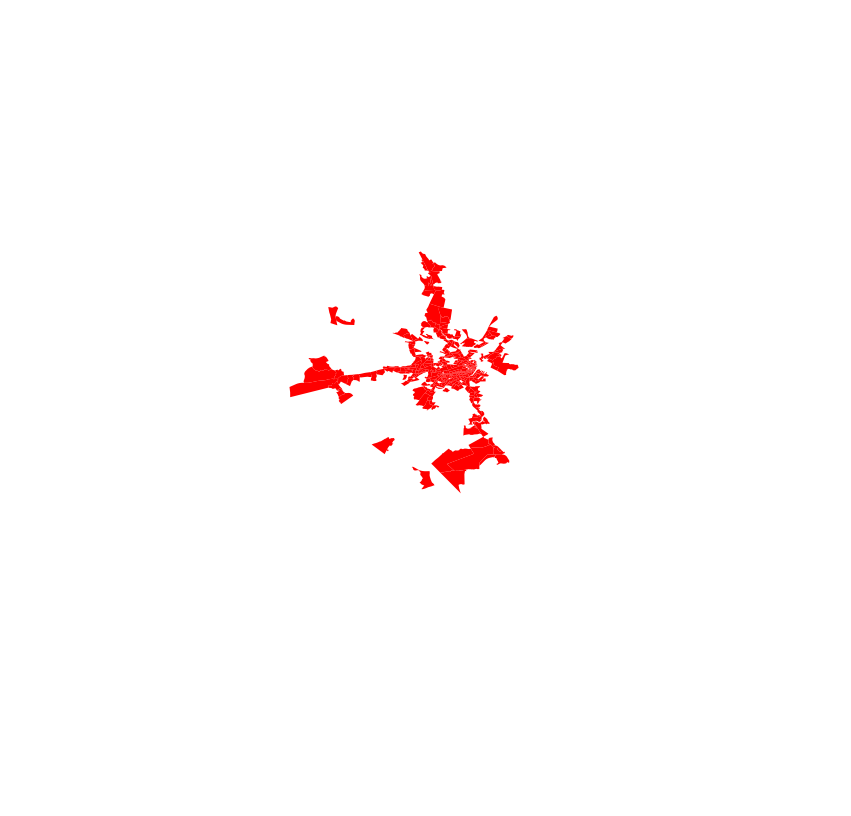

In [32]:
plotter(0.250,'in',18)

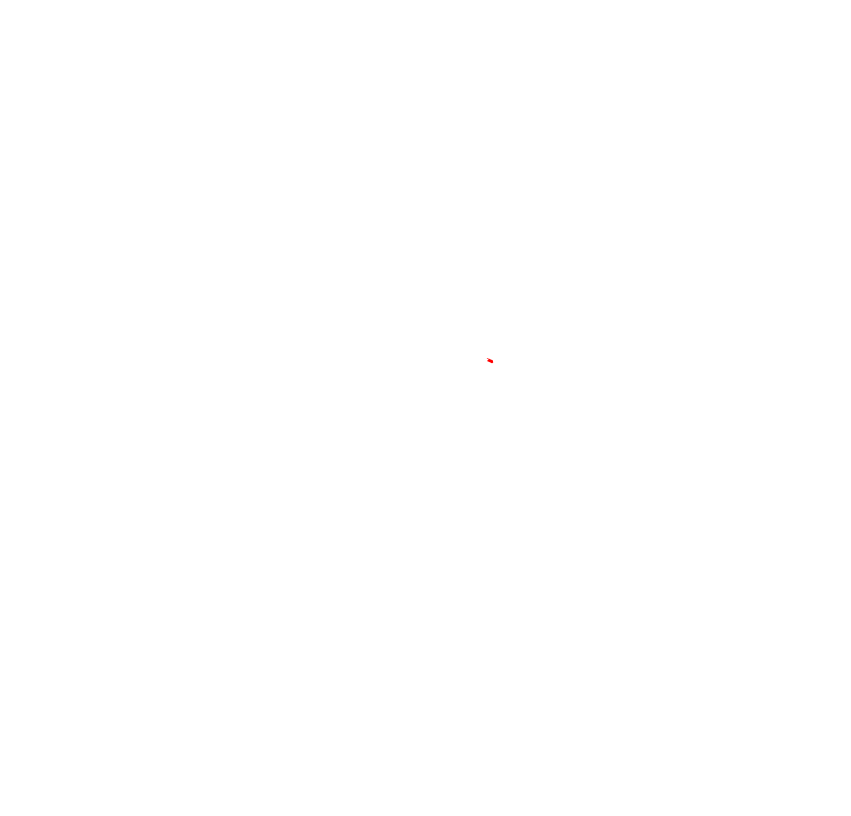

In [32]:
plotter(0.655,'in',18)

### PLOT ALL MAPS FOR RESOURCE ALLOCATION FOR GIVEN HOURS

In [150]:
cents = np.arange(0,1.005,0.005)
#for hour in [4,18]:
for hour in [4,18]:
    print(hour)
    #in_results= getCentrality(hour,'in')
    #out_results = getCentrality(hour,'out')
    for kind in ['out','in']:
        print(kind)
        for mini in cents:
            print(mini)
            plotter(mini,kind,hour)

4
out
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21
0.215
0.22
0.225
0.23
0.23500000000000001
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.28500000000000003
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.34500000000000003
0.35000000000000003
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41000000000000003
0.41500000000000004


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.42


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.425


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.43


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.435


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.44


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.445


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.45


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.455


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.46


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.465


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.47000000000000003


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.47500000000000003


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.48


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.485


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.49


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.495


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.5


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.505


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.51


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.515


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.52


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.525


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.53


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.535


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.54


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.545


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.55


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.555


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.56


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.5650000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.5700000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.5750000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.58


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.585


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.59


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.595


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.6


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.605


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.61


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.615


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.62


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.625


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.63


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.635


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.64


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.645


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.65


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.655


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.66


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.665


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.67


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.675


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.68


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.685


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.6900000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.6950000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.7000000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.705


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.71


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.715


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.72


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.725


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.73


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.735


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.74


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.745


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.75


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.755


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.76


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.765


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.77


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.775


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.78


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.785


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.79


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.795


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.805


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.81


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8150000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8200000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8250000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8300000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.835


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.84


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.845


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.85


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.855


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.86


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.865


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.87


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.875


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.88


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.885


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.89


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.895


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.905


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.91


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.915


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.92


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.925


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.93


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.935


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9400000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9450000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9550000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.96


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.965


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.97


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.975


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.98


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.985


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.99


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.995


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


1.0


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


in
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21
0.215
0.22
0.225
0.23
0.23500000000000001
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.28500000000000003
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.34500000000000003
0.35000000000000003
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41000000000000003
0.41500000000000004
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47000000000000003
0.47500000000000003
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.5650000000000001
0.5700000000000001
0.5750000000000001
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.6900000000000001
0.6950000000000001
0.7000000000000001
0.705

/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.75


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.755


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.76


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.765


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.77


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.775


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.78


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.785


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.79


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.795


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.805


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.81


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8150000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8200000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8250000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8300000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.835


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.84


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.845


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.85


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.855


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.86


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.865


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.87


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.875


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.88


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.885


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.89


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.895


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.905


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.91


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.915


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.92


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.925


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.93


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.935


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9400000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9450000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9550000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.96


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.965


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.97


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.975


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.98


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.985


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.99


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.995


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


1.0


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


18
out
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21
0.215
0.22
0.225
0.23
0.23500000000000001
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.28500000000000003
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.34500000000000003
0.35000000000000003
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41000000000000003
0.41500000000000004
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47000000000000003
0.47500000000000003
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.5650000000000001
0.5700000000000001
0.5750000000000001
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.6900000000000001
0.6950000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.7000000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.705


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.71


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.715


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.72


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.725


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.73


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.735


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.74


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.745


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.75


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.755


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.76


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.765


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.77


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.775


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.78


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.785


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.79


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.795


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.805


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.81


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8150000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8200000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8250000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8300000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.835


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.84


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.845


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.85


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.855


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.86


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.865


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.87


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.875


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.88


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.885


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.89


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.895


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.905


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.91


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.915


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.92


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.925


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.93


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.935


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9400000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9450000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9550000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.96


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.965


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.97


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.975


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.98


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.985


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.99


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.995


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


1.0


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


in
0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.17500000000000002
0.18
0.185
0.19
0.195
0.2
0.20500000000000002
0.21
0.215
0.22
0.225
0.23
0.23500000000000001
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.28500000000000003
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.34500000000000003
0.35000000000000003
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41000000000000003
0.41500000000000004
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47000000000000003
0.47500000000000003
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.5650000000000001
0.5700000000000001
0.5750000000000001
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.665


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.67


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.675


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.68


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.685


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.6900000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.6950000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.7000000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.705


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.71


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.715


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.72


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.725


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.73


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.735


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.74


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.745


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.75


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.755


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.76


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.765


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.77


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.775


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.78


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.785


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.79


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.795


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.805


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.81


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8150000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8200000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8250000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.8300000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.835


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.84


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.845


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.85


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.855


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.86


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.865


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.87


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.875


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.88


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.885


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.89


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.895


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.905


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.91


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.915


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.92


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.925


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.93


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.935


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9400000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9450000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9500000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.9550000000000001


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.96


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.965


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.97


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.975


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.98


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.985


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.99


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


0.995


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


1.0


/usr/local/anaconda3/lib/python3.6/site-packages/geopandas/plotting.py:405: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  "empty. Nothing has been displayed.", UserWarning)


In [158]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [159]:
%%cython

import numpy as np
cimport numpy as np
import time
cimport cython

DTYPE = np.uint32
ctypedef np.uint32_t DTYPE_t

def latticegen(int N, float p):
    cdef np.ndarray[DTYPE_t, ndim=2] lattice
    lattice = np.ones([N,N], dtype=DTYPE)*(np.random.random([N,N])<p)
    return lattice

cdef int find(int x, labellist):
    while labellist[x] != x:
        x = labellist[x]
    return x
    
cdef int union(int a, int b, labellist):
    cdef int above, left
    above = find(b, labellist)
    left = find(a, labellist)
    labellist[above] = left
    return left

def percolate(int N, int p, np.ndarray[DTYPE_t, ndim=2] labels, labellist):
    cdef int left, above, x, y
    cdef int largest_label = 0
    for x from 0<= x < N:
        for y from 0<= y < N:
            if labels[y,x]:
                if x!=0: left = labels[y, x-1]
                else: left = 0
                if y!=0: above = labels[y-1, x]
                else: above = 0
                if left == 0 and above == 0:
                    largest_label += 1
                    labellist.append(largest_label)
                    labels[y,x] = largest_label
                else:
                    if left != 0:
                        if above != 0:
                            labels[y,x] = union(left, above, labellist)
                        labels[y,x] = find(left, labellist)
                    else:
                        labels[y,x] = find(above, labellist)
    coll = collapse(N, labels, labellist)
    return coll
    
def collapse(int N, np.ndarray[DTYPE_t, ndim=2] labels, labellist):
    cdef int x, y
    newlist = [find(i, labellist) for i in range(len(labellist))]
    for x from 0<= x < N:
        for y from 0<= y < N:
            if labels[y,x]:
                labels[y,x] = newlist[labels[y,x]]
    return labels

    
def main(int N, float p):#, np.ndarray[DTYPE_t, ndim=2] labels):
    labels = latticegen(N,p)
    labellist = [0]
    s = percolate(N, p, labels, labellist)
    return s



In [165]:
def do_perc(image):
    labellist=[0]
    shape = image.shape[0]

    M = percolate(shape,0,image.astype(np.uint32),labellist)
    ## REDUCE LABELS 
    unique, counts = np.unique(M, return_counts=True)
    #print(unique,counts)
    for index,value in enumerate(unique):
        #print(index)
        M[M==value] =index
    if len(unique)>1:
        CLUSTER_SIZE = counts[unique!=0][counts[unique!=0] == counts[unique!=0].max()][0] #FIND  MAX FREQUENCY OF NON-ZERO CLUSTER
        TOTAL = sum(counts[unique!=0])
        NUM_CLUSTERS = len(unique)-1
    else:
        CLUSTER_SIZE =0
        TOTAL = 0
        NUM_CLUSTERS = 0 
    #plt.figure(figsize=(10,10))
    #plt.imshow(M)
    #plt.axis('off')
    #plt.colorbar()
    
    #return unique,counts
    
    return NUM_CLUSTERS,CLUSTER_SIZE, TOTAL #Do not consider cluster of 0 values as a cluster
def load_binary(kind,cent,hour):
    img = plt.imread('{}_centrality_from_greater_than_{}_hour_{}.png'.format(kind,cent,hour))[:,:,1]
    #img = plt.imread('centrality_from_0.7_to_0.8.png')[:,:,1]/255.

    unique, counts = np.unique(img.flatten(),return_counts=True)
    
    copy = img<unique[-1].astype(int);
    #plt.imshow(copy)
    return copy

In [161]:
load_binary('in',0.130,18)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

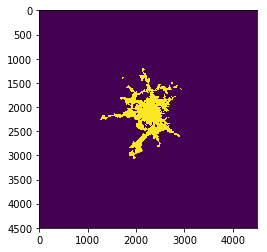

In [164]:
load_binary('in',0.110,18)

In [36]:
cents = np.arange(0,1.005,0.005)
print(cents)

[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295
 0.3   0.305 0.31  0.315 0.32  0.325 0.33  0.335 0.34  0.345 0.35  0.355
 0.36  0.365 0.37  0.375 0.38  0.385 0.39  0.395 0.4   0.405 0.41  0.415
 0.42  0.425 0.43  0.435 0.44  0.445 0.45  0.455 0.46  0.465 0.47  0.475
 0.48  0.485 0.49  0.495 0.5   0.505 0.51  0.515 0.52  0.525 0.53  0.535
 0.54  0.545 0.55  0.555 0.56  0.565 0.57  0.575 0.58  0.585 0.59  0.595
 0.6   0.605 0.61  0.615 0.62  0.625 0.63  0.635 0.64  0.645 0.65  0.655]


### CALCULATE LARGEST CLUSTER AREA AND TOTAL LAND AREA USING HOSHEN KOPELMAN ALGORITHM

In [ ]:
for hour in [4,18]:
    for kind in ['out','in']:    
        num_clusters= []
        cluster_sizes=[]
        total_sizes = []
        for i in cents:
            print(round(i,4))
            num_cluster,size,total = do_perc(load_binary(kind,round(i,4),hour))
            num_clusters.append(num_cluster)
            cluster_sizes.append(size)
            total_sizes.append(total)
        a = list(zip(cents,cluster_sizes,num_clusters,total_sizes))
        with open('{}_cluster_analysis_BOSTON_hour_{}.txt'.format(kind,hour),'w') as f:
            for i in a:
                f.write(str(i)+'\n')

0.0
0.005
0.01
0.015
0.02
0.025
0.03
0.035
0.04
0.045
0.05
0.055
0.06
0.065
0.07
0.075
0.08
0.085
0.09
0.095
0.1
0.105
0.11
0.115
0.12
0.125
0.13
0.135
0.14
0.145
0.15
0.155
0.16
0.165
0.17
0.175
0.18
0.185
0.19
0.195
0.2
0.205
0.21
0.215
0.22
0.225
0.23
0.235
0.24
0.245
0.25
0.255
0.26
0.265
0.27
0.275
0.28
0.285
0.29
0.295
0.3
0.305
0.31
0.315
0.32
0.325
0.33
0.335
0.34
0.345
0.35
0.355
0.36
0.365
0.37
0.375
0.38
0.385
0.39
0.395
0.4
0.405
0.41
0.415
0.42
0.425
0.43
0.435
0.44
0.445
0.45
0.455
0.46
0.465
0.47
0.475
0.48
0.485
0.49
0.495
0.5
0.505
0.51
0.515
0.52
0.525
0.53
0.535
0.54
0.545
0.55
0.555
0.56
0.565
0.57
0.575
0.58
0.585
0.59
0.595
0.6
0.605
0.61
0.615
0.62
0.625
0.63
0.635
0.64
0.645
0.65
0.655
0.66
0.665
0.67
0.675
0.68
0.685
0.69
0.695
0.7
0.705
0.71
0.715
0.72
0.725
0.73
0.735
0.74
0.745
0.75
0.755
0.76
0.765
0.77
0.775
0.78
0.785
0.79
0.795
0.8
0.805
0.81
0.815
0.82
0.825
0.83
0.835
0.84
0.845
0.85
0.855
0.86
0.865
0.87
0.875
0.88
0.885
0.89
0.895
0.9
0.905
0.91
0.91

8728238.0
8728238.0
8728238.0
8728238.0


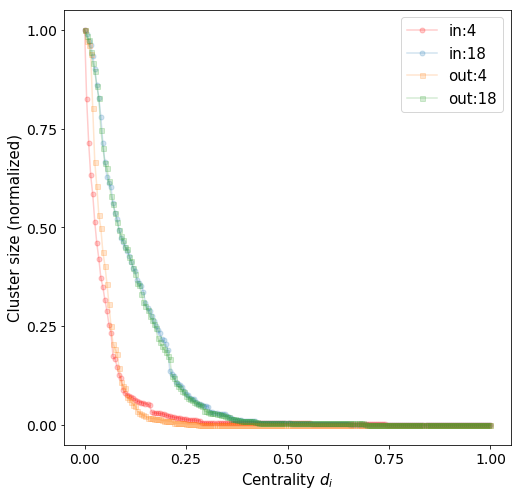

In [112]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(8,8))
for kind in ['in','out']:
    for hour in [4,18]:
        cents = []
        cluster_sizes = []
        num_clusters=[]
        with open('{}_cluster_analysis_BOSTON_hour_{}.txt'.format(kind,hour)) as f:
            for line in f:
                line = line.replace(',','')
                values = line[1:-2].split()

                cents.append(float(values[0]))
                cluster_sizes.append(float(values[1]))
                num_clusters.append(float(values[2]))
                #print(values[2])

        print(cluster_sizes[0])

        if hour ==4:
            if kind=='in':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes),'o-',  color='r',markersize= 5,alpha=0.2,label=kind+":"+str(hour))
            elif kind=='out':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes), 's-',markersize= 5,alpha=0.2,label=kind+":"+str(hour))
        elif hour ==18:
            if kind=='in':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes), 'o-',markersize=5,alpha=0.2,label=kind+":"+str(hour))
            elif kind=='out':
                plt.plot(cents, np.array(cluster_sizes)/max(cluster_sizes), 's-',markersize= 5,alpha=0.2,label=kind+":"+str(hour))
plt.title("")
plt.xlabel("Centrality $d_{i}$",fontsize=15)
plt.ylabel("Cluster size (normalized)",fontsize=15)

plt.yticks(np.linspace(0,1,5),fontsize=14)
plt.xticks(np.linspace(0,1,5),fontsize=14)
plt.legend(fontsize=15)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
plt.savefig('BOSTON_CLUSTER.pdf'.format(kind,hour),bbox_inches='tight',dpi=1000)
